In [1]:
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import plot_tree, export_graphviz, export_text
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv
import pprint
# para silenciar warnings
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [2]:
def check_special_date(weekofyear):
    weeks = [13, 14, 16, 18, 27, 40, 41, 44, 50,51]
    return 1 if weekofyear in weeks else 0
    
def create_features(data):
    df = data.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week
    #df['is_special_date'] = df['weekofyear'].apply(check_special_date)
    return df
    
train = pd.read_csv('treino_calca.csv')
test  = pd.read_csv('teste_calca.csv')

serie_temporal = pd.concat([train, test])

train = serie_temporal.drop_duplicates(keep=False)

train = train.set_index('data_semana_comercial')
test = test.set_index('data_semana_comercial')
serie_temporal['data_semana_comercial'] = pd.to_datetime(serie_temporal['data_semana_comercial'])
serie_temporal = serie_temporal.set_index('data_semana_comercial')

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

train = create_features(train)
test = create_features(test)

In [100]:
serie_temporal.isnull().sum().to_frame().rename(columns={0:'Nulls'})

,Nulls
item,0
cluster_clima,0
data_semana_comercial,0
venda,0


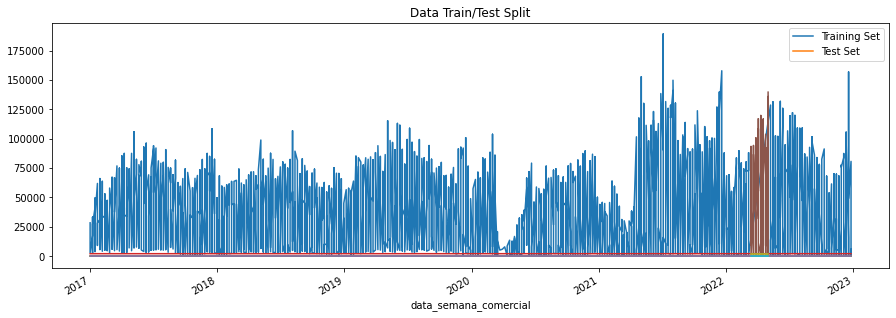

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [14]:
fig = px.area(train, facet_col="cluster_clima", x="weekofyear", y="venda", facet_col_wrap=3, color='cluster_clima')
fig.show()

In [4]:
train['cluster_clima'] = train['cluster_clima'].map({'W': 1, 'SUL':2, 'SPO':3, 'NOR':4, 'RIO': 5, 'URU':6, 'ARG': 7})
test['cluster_clima'] = test['cluster_clima'].map({'W': 1, 'SUL':2, 'SPO':3, 'NOR':4, 'RIO': 5, 'URU':6, 'ARG': 7})
test['item'].replace({'calca': 1}, inplace=True)
train['item'].replace({'calca': 1}, inplace=True)
test['year'].replace({'2022': 1}, inplace=True)
train['year'].replace({'2022': 1}, inplace=True)


In [5]:
FEATURES = ['quarter', 'month', 'year', 'item', 'cluster_clima', 'weekofyear'] 
TARGET = 'venda'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [94]:
X_train.head(3)

,quarter,month,year,item,cluster_clima,weekofyear
data_semana_comercial,,,,,,
2022-03-06,1,3,2022,1,3,9
2021-07-18,3,7,2021,1,3,28
2017-10-15,4,10,2017,1,3,41


In [103]:
# ohe = OneHotEncoder(sparse=False)
# X_train = ohe.fit_transform(X_train)
# X_test = ohe.transform(X_test)


In [6]:
import xgboost as xgb

In [7]:
def calc_ape(test, pred):
    after_prediction = test[['cluster_clima', 'venda']].reset_index().drop(columns='data_semana_comercial')
    after_prediction['pred'] = pred
    after_prediction.head(3)
    a = after_prediction.groupby(by='cluster_clima')['venda', 'pred'].sum()
    a['APE'] = (abs((a['venda'] - a['pred'])/a['venda']))*100
    a.index = a.index.map({1 :'W', 2:'SUL', 3:'SPO', 4:'NOR', 5:'RIO', 6:'URU', 7:'ARG'})
    return a

In [8]:
params = {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 700}
reg = xgb.XGBRegressor(**params)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
pred = reg.predict(X_test)
MAPE = mape(y_test, pred)
RMSE = mse(y_test, pred, squared=False)
APE = calc_ape(test, pred)
print('  RMSE=', RMSE, '  MAPE=', MAPE)


[0]	validation_0-rmse:30923.83127	validation_1-rmse:41756.82365
[100]	validation_0-rmse:7279.05646	validation_1-rmse:17675.80204
[200]	validation_0-rmse:5047.09166	validation_1-rmse:15341.85434
[300]	validation_0-rmse:4127.59096	validation_1-rmse:14675.56417
[400]	validation_0-rmse:3462.96808	validation_1-rmse:14724.74563
[500]	validation_0-rmse:3102.08094	validation_1-rmse:14708.23340
[600]	validation_0-rmse:2865.29050	validation_1-rmse:14821.66541
[699]	validation_0-rmse:2535.99454	validation_1-rmse:15065.86496
  RMSE= 15065.86495284577   MAPE= 0.19196095688388404


In [9]:
APE

,venda,pred,APE
cluster_clima,,,
W,255840,246562.828125,3.626162
SUL,409341,391046.812500,4.469180
SPO,884825,720587.500000,18.561580
NOR,577490,597456.875000,3.457527
RIO,818268,686673.562500,16.082071
URU,76635,73982.796875,3.460825
ARG,8835,10662.294922,20.682455


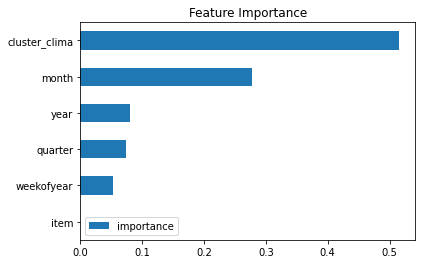

In [10]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

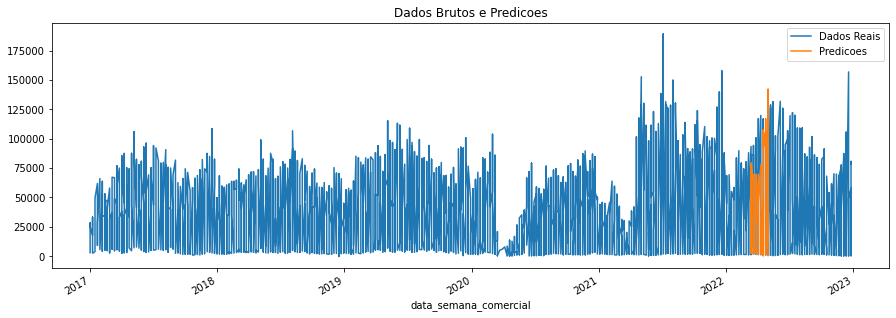

In [11]:
test['predicao'] = pred
serie_temporal = serie_temporal.merge(test[['predicao']],
                                      how='left',
                                      left_index=True,
                                      right_index=True)
ax = serie_temporal[['venda']].plot(figsize=(15, 5))
serie_temporal['predicao'].plot(ax=ax, style='-')
plt.legend(['Dados Reais', 'Predicoes'])
ax.set_title('Dados Brutos e Predicoes')
plt.show()

# Modelo Baseline - XGBOOST

Foi só um primeiro teste

O modelo acima já contém os parâmetros otimizados

In [ ]:
!pip install xgboost

In [83]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01,
                       )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:51173.43239	validation_1-rmse:67313.64978
[100]	validation_0-rmse:25066.77493	validation_1-rmse:38018.26050
[200]	validation_0-rmse:17755.42944	validation_1-rmse:29023.67845
[300]	validation_0-rmse:15265.69345	validation_1-rmse:25801.51731
[400]	validation_0-rmse:14184.56641	validation_1-rmse:23526.65299
[500]	validation_0-rmse:13533.52328	validation_1-rmse:22899.76657
[600]	validation_0-rmse:13111.26924	validation_1-rmse:22607.56014
[700]	validation_0-rmse:12770.31953	validation_1-rmse:22047.75415
[800]	validation_0-rmse:12407.33158	validation_1-rmse:21444.37424
[900]	validation_0-rmse:12108.71804	validation_1-rmse:21133.39637
[927]	validation_0-rmse:12023.77695	validation_1-rmse:21135.89623


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [84]:
pred = reg.predict(X_test)

In [85]:
# bl = base line
MAPE_bl = mape(y_test, pred)
MAE_bl = mae(y_test, pred)
RMSE_bl = mse(y_test, pred, squared=False)
print('MAE=', MAE_bl, '  RMSE=', RMSE_bl, '  MAPE=', MAPE_bl)

MAE= 16346.319610595703   RMSE= 21097.23405730036   MAPE= 0.7603020312147807


In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

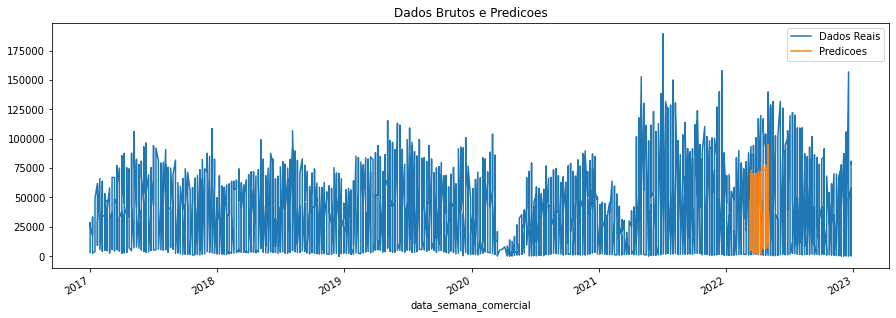

In [82]:
test['predicao'] = pred
serie_temporal = serie_temporal.merge(test[['predicao']],
                                      how='left',
                                      left_index=True,
                                      right_index=True)
ax = serie_temporal[['venda']].plot(figsize=(15, 5))
serie_temporal['predicao'].plot(ax=ax, style='-')
plt.legend(['Dados Reais', 'Predicoes'])
ax.set_title('Dados Brutos e Predicoes')
plt.show()

In [83]:
score = np.sqrt(mse(test['venda'],
                                   test['predicao']))
print(f'Escore do RMSE no conjunto de teste: {score:0.2f}')

Escore do RMSE no conjunto de teste: 21486.11


# GRID SEARCH

In [25]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1000, 2000, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'booster': ['gbtree', 'gblinear'] 
}

In [99]:
model = xgb.XGBRegressor()

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=tscv)

test_aux = test.drop(columns='predicao')
grid_search.fit(train.drop(columns='venda'), train['venda'])

# Get the best hyperparameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)
print(best_estimator)

NameError: name 'param_grid' is not defined